
# PatchCore Clean Domain Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/code_refactor/notebooks/04_patchcore_clean.ipynb)

The objective of this notebook is to train PatchCore on clean domain images only, i.e. without domain shifts.

## Setup - Mount Drive & Configure Paths

In [1]:
from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone -b code_refactor https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location (directly from Drive)
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

# Output directories
MODELS_DIR = PROJECT_ROOT / 'outputs' / 'models'
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

Mounted at /content/drive
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 1223, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1223 (delta 24), reused 50 (delta 15), pack-reused 1126 (from 3)
Receiving objects: 100% (1223/1223), 418.05 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (642/642), done.
Filtering content: 100% (30/30), 1.32 GiB | 28.64 MiB/s, done.
Done!



Install FAISS, **must be done before importing PatchCore related code**. Used to speed up coreset sampling.


In [2]:
!pip install faiss-cpu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 111.4 MB/s eta 0:00:00


## Imports & Configurations

In [3]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.data.splitter import load_splits
from src.models.patchcore import PatchCore
from src.utils.utils import custom_collate_fn, denormalize_image

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Set seed for reproducibility
set_seed(config.seed)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Device: cuda


## Load Clean Splits

Load clean domain splits computed in previous notebook.

In [4]:
splits = load_splits(paths.get_split_path('clean'))

print("Dataset splits loaded:")
print("=" * 70)
for class_name in config.dataset.classes:
    print(f"\n{class_name.upper()}:")
    for split_name in ['train', 'val', 'test']:
        split_data = splits[class_name][split_name]
        n_normal = sum(1 for l in split_data['labels'] if l == 0)
        n_anomalous = sum(1 for l in split_data['labels'] if l == 1)
        print(f"  {split_name:5s}: {len(split_data['labels']):4d} images "
              f"({n_normal:3d} normal, {n_anomalous:3d} anomalous)")

Dataset splits loaded:

HAZELNUT:
  train:  312 images (312 normal,   0 anomalous)
  val  :  100 images ( 79 normal,  21 anomalous)
  test :   89 images ( 40 normal,  49 anomalous)

CARPET:
  train:  224 images (224 normal,   0 anomalous)
  val  :   82 images ( 56 normal,  26 anomalous)
  test :   91 images ( 28 normal,  63 anomalous)

ZIPPER:
  train:  192 images (192 normal,   0 anomalous)
  val  :   83 images ( 48 normal,  35 anomalous)
  test :  116 images ( 32 normal,  84 anomalous)


## Train PatchCore Models

Train one PatchCore model per class using the clean splits.

In [5]:
# Transform
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Hyperparameters
CORESET_RATIO = config.patchcore.coreset_sampling_ratio
BATCH_SIZE = 8
NUM_WORKERS = 0  # set to 0 for Colab

print("\nTraining Configuration:")
print("=" * 70)
print(f"Coreset ratio: {CORESET_RATIO*100:.1f}%")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Image size: {config.dataset.image_size}")
print(f"Backbone layers: {config.patchcore.layers}")
print(f"Patch size: {config.patchcore.patch_size}")
print(f"N neighbors: {config.patchcore.n_neighbors}")


Training Configuration:
Coreset ratio: 5.0%
Batch size: 8
Num workers: 0
Image size: 224
Backbone layers: ['layer2', 'layer3']
Patch size: 3
N neighbors: 9


In [6]:
trained_models = {}
training_stats = {}

for class_name in config.dataset.classes:
    print("\n" + "=" * 70)
    print(f"Training PatchCore for: {class_name.upper()}")
    print("=" * 70)

    # Create train dataset (only normal images)
    train_split = splits[class_name]['train']
    train_dataset = MVTecDataset.from_split(
        train_split,
        transform=transform,
        phase='train'
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    print(f"\nTrain dataset: {len(train_dataset)} images")

    # Initialize PatchCore
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=CORESET_RATIO,
        n_neighbors=config.patchcore.n_neighbors,
        device=device
    )

    # Fit model
    start_time = time.time()
    model.fit(train_loader, apply_coreset=True)
    training_time = time.time() - start_time

    # Save model
    model.save(paths.MODELS, class_name, domain='clean')

    # Store statistics
    training_stats[class_name] = {
        'n_train_images': len(train_dataset),
        'memory_bank_size': len(model.memory_bank),
        'training_time': training_time,
        'spatial_dims': model.spatial_dims
    }

    trained_models[class_name] = model

    print(f"\nCompleted {class_name.upper()}:")
    print(f"  Memory bank size: {len(model.memory_bank)}")
    print(f"  Training time: {training_time:.2f}s")
    print(f"  Spatial dims: {model.spatial_dims}")

print("\n" + "=" * 70)
print("All PatchCore models trained successfully!")
print("=" * 70)


Training PatchCore for: HAZELNUT

Train dataset: 312 images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]
Extracting features: 100%|██████████| 39/39 [04:46<00:00,  7.34s/it]



Completed HAZELNUT:
  Memory bank size: 12230
  Training time: 2280.42s
  Spatial dims: (28, 28)

Training PatchCore for: CARPET

Train dataset: 224 images


Extracting features: 100%|██████████| 28/28 [03:24<00:00,  7.31s/it]



Completed CARPET:
  Memory bank size: 8780
  Training time: 1260.52s
  Spatial dims: (28, 28)

Training PatchCore for: ZIPPER

Train dataset: 192 images


Extracting features: 100%|██████████| 24/24 [02:40<00:00,  6.70s/it]



Completed ZIPPER:
  Memory bank size: 7526
  Training time: 919.21s
  Spatial dims: (28, 28)

All PatchCore models trained successfully!


## Training Statistics Summary

In [7]:
import pandas as pd

# Create summary table
stats_df = pd.DataFrame(training_stats).T
stats_df['training_time'] = stats_df['training_time'].apply(lambda x: f"{x:.2f}s")

print("\nTraining Statistics Summary:")
print(stats_df.to_string())

# Save statistics
stats_output_path = paths.RESULTS / 'patchcore_clean_training_stats.csv'
stats_df.to_csv(stats_output_path)
print(f"\nStatistics saved to: {stats_output_path}")


Training Statistics Summary:
         n_train_images memory_bank_size training_time spatial_dims
hazelnut            312            12230      2280.42s     (28, 28)
carpet              224             8780      1260.52s     (28, 28)
zipper              192             7526       919.21s     (28, 28)

Statistics saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_clean_training_stats.csv


## Quick Validation Test

Test predictions on a few validation images to verify the model works correctly.

In [8]:
# Test on validation set
class_name = 'hazelnut'  # Change to test different classes
model = trained_models[class_name]

# Load validation data
val_split = splits[class_name]['val']
val_dataset = MVTecDataset.from_split(
    val_split,
    transform=transform,
    phase='val'
)

# Select images: 4 normal + 4 anomalous
normal_idx = [i for i, l in enumerate(val_dataset.labels) if l == 0][:4]
anomalous_idx = [i for i, l in enumerate(val_dataset.labels) if l == 1][:4]
test_indices = normal_idx + anomalous_idx

# Get predictions
test_images = []
test_labels = []
for idx in test_indices:
    img, mask, label, _ = val_dataset[idx]
    test_images.append(img)
    test_labels.append(label)

test_batch = torch.stack(test_images)
scores, heatmaps = model.predict(test_batch, return_heatmaps=True)

print(f"\nPrediction scores for {class_name}:")
print(f"Normal images (0-3): {scores[:4]}")
print(f"Anomalous images (4-7): {scores[4:]}")
print(f"\nScore statistics:")
print(f"  Normal - mean: {scores[:4].mean():.3f}, std: {scores[:4].std():.3f}")
print(f"  Anomalous - mean: {scores[4:].mean():.3f}, std: {scores[4:].std():.3f}")


Prediction scores for hazelnut:
Normal images (0-3): [352.41895 368.23682 304.5879  317.71045]
Anomalous images (4-7): [881.1279  650.3479  563.10864 937.21436]

Score statistics:
  Normal - mean: 335.739, std: 25.641
  Anomalous - mean: 757.950, std: 155.604


## Visualize Predictions

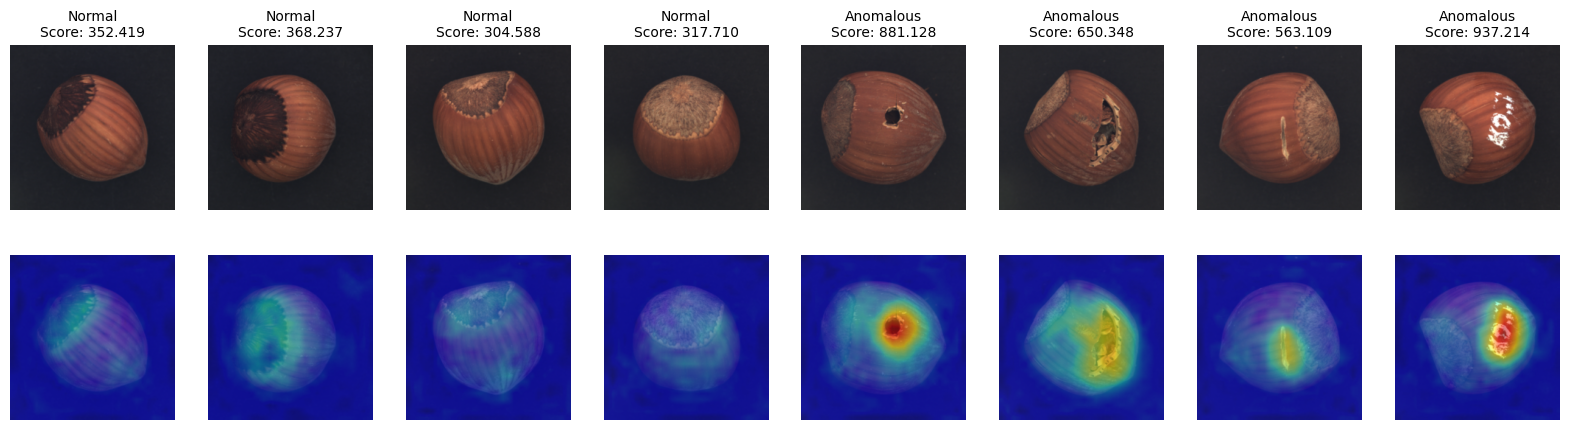

<Figure size 640x480 with 0 Axes>

In [9]:
# Visualization
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

mean = config.dataset.normalize.mean
std = config.dataset.normalize.std

# Calculate global vmax for consistent heatmap scaling
vmax_global = np.max([h.max() for h in heatmaps])

for i, (img, score, heatmap, label) in enumerate(
    zip(test_images, scores, heatmaps, test_labels)
):
    # Denormalize image
    img_np = denormalize_image(img, mean, std)

    # Original image
    axes[0, i].imshow(img_np)
    axes[0, i].set_title(
        f"{'Normal' if label == 0 else 'Anomalous'}\nScore: {score:.3f}",
        fontsize=10
    )
    axes[0, i].axis('off')

    # Heatmap overlay with global normalization
    axes[1, i].imshow(img_np)
    axes[1, i].imshow(heatmap, alpha=0.5, cmap='jet', vmin=0, vmax=vmax_global)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Heatmap', fontsize=12)

plt.show()

plt.suptitle(f'PatchCore Predictions - {class_name.upper()}', fontsize=16, y=1.02)
plt.tight_layout()

## Save Visualizations

In [10]:
# Save visualization for each class
for class_name in config.dataset.classes:
    model = trained_models[class_name]
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split, transform=transform, phase='val'
    )

    # Select images
    normal_idx = [i for i, l in enumerate(val_dataset.labels) if l == 0][:4]
    anomalous_idx = [i for i, l in enumerate(val_dataset.labels) if l == 1][:4]
    test_indices = normal_idx + anomalous_idx

    test_images = []
    test_labels = []
    for idx in test_indices:
        img, _, label, _ = val_dataset[idx]
        test_images.append(img)
        test_labels.append(label)

    test_batch = torch.stack(test_images)
    scores, heatmaps = model.predict(test_batch, return_heatmaps=True)

    # Calculate global vmax for consistent heatmap scaling
    vmax_global = np.max([h.max() for h in heatmaps])

    # Create figure
    fig, axes = plt.subplots(2, 8, figsize=(20, 5))

    for i, (img, score, heatmap, label) in enumerate(
        zip(test_images, scores, heatmaps, test_labels)
    ):
        img_np = denormalize_image(img, mean, std)

        axes[0, i].imshow(img_np)
        axes[0, i].set_title(
            f"{'Normal' if label == 0 else 'Anomalous'}\nScore: {score:.3f}",
            fontsize=10
        )
        axes[0, i].axis('off')

        axes[1, i].imshow(img_np)
        axes[1, i].imshow(heatmap, alpha=0.5, cmap='jet', vmin=0, vmax=vmax_global)
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Heatmap', fontsize=12)

    plt.suptitle(f'PatchCore Predictions - {class_name.upper()}', fontsize=16, y=1.02)
    plt.tight_layout()

    # Save
    save_path = paths.VISUALIZATIONS / f'patchcore_clean_{class_name}_validation.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


    print(f"Saved visualization: {save_path}")


Saved visualization: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/patchcore_clean_hazelnut_validation.png
Saved visualization: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/patchcore_clean_carpet_validation.png
Saved visualization: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/patchcore_clean_zipper_validation.png


## Summary
- Trained PatchCore models for all classes
- Memory banks saved in `outputs/models/`
- Validation predictions show clear separation between normal and anomalous samples

## Save Complete Training Metadata

Save comprehensive metadata for reproducibility and downstream evaluation.

In [11]:
import json
from datetime import datetime

# Collect validation scores for threshold calibration
validation_predictions = {}

for class_name in config.dataset.classes:
    model = trained_models[class_name]

    # Load validation set
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split, transform=transform, phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Get predictions for all validation images
    all_scores = []
    all_labels = []
    all_paths = []

    for images, masks, labels, image_paths in val_loader:
        scores, _ = model.predict(images, return_heatmaps=False)

        all_scores.extend(scores.tolist())
        all_labels.extend(labels.tolist())
        all_paths.extend(image_paths)

    validation_predictions[class_name] = {
        'scores': all_scores,
        'labels': all_labels,
        'image_paths': all_paths,
        'n_normal': sum(1 for l in all_labels if l == 0),
        'n_anomalous': sum(1 for l in all_labels if l == 1),
        'score_stats': {
            'normal_mean': float(np.mean([s for s, l in zip(all_scores, all_labels) if l == 0])),
            'normal_std': float(np.std([s for s, l in zip(all_scores, all_labels) if l == 0])),
            'anomalous_mean': float(np.mean([s for s, l in zip(all_scores, all_labels) if l == 1])),
            'anomalous_std': float(np.std([s for s, l in zip(all_scores, all_labels) if l == 1]))
        }
    }

    print(f"{class_name}: Normal scores: {validation_predictions[class_name]['score_stats']['normal_mean']:.3f} +/- "
          f"{validation_predictions[class_name]['score_stats']['normal_std']:.3f}, "
          f"Anomalous: {validation_predictions[class_name]['score_stats']['anomalous_mean']:.3f} +/- "
          f"{validation_predictions[class_name]['score_stats']['anomalous_std']:.3f}")

hazelnut: Normal scores: 294.859 +/- 35.932, Anomalous: 708.115 +/- 181.716
carpet: Normal scores: 118.662 +/- 14.361, Anomalous: 529.987 +/- 212.536
zipper: Normal scores: 98.736 +/- 13.195, Anomalous: 346.559 +/- 166.916


In [12]:
# Ensure paths object is not corrupted (safety check)
if not hasattr(paths, 'MODELS'):
    paths = ProjectPaths(PROJECT_ROOT)

# Create comprehensive metadata
metadata = {
    'notebook': '04_patchcore_clean.ipynb',
    'timestamp': datetime.now().isoformat(),
    'seed': config.seed,
    'device': device,

    'configuration': {
        'backbone': config.patchcore.backbone,
        'layers': config.patchcore.layers,
        'patch_size': config.patchcore.patch_size,
        'coreset_ratio': CORESET_RATIO,
        'n_neighbors': config.patchcore.n_neighbors,
        'batch_size': BATCH_SIZE,
        'image_size': config.dataset.image_size,
        'normalize_mean': config.dataset.normalize.mean,
        'normalize_std': config.dataset.normalize.std
    },

    'training_statistics': {},
    'validation_predictions': validation_predictions,

    'models_saved': {},
    'splits_used': 'clean_splits.json'
}

# Add training statistics per class
for class_name in config.dataset.classes:
    stats = training_stats[class_name]
    metadata['training_statistics'][class_name] = {
        'n_train_images': stats['n_train_images'],
        'memory_bank_size': stats['memory_bank_size'],
        'training_time_seconds': stats['training_time'],
        'spatial_dims': stats['spatial_dims'],
        'compression_ratio': stats['memory_bank_size'] / (stats['n_train_images'] * stats['spatial_dims'][0] * stats['spatial_dims'][1]) if stats['n_train_images'] > 0 else 0
    }

    metadata['models_saved'][class_name] = {
        'memory_bank': f"patchcore_{class_name}_clean.npy",
        'config': f"patchcore_{class_name}_clean_config.pth",
        'location': str(paths.MODELS)
    }

# Save metadata
metadata_path = paths.RESULTS / 'patchcore_clean_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nMetadata saved to: {metadata_path}")
print(f"\nSummary:")
print(f"  Classes trained: {len(config.dataset.classes)}")
print(f"  Total memory bank samples: {sum(stats['memory_bank_size'] for stats in training_stats.values())}")
print(f"  Average training time: {np.mean([stats['training_time'] for stats in training_stats.values()]):.2f}s")
print(f"  Models saved in: {paths.MODELS}")
print(f"  Results saved in: {paths.RESULTS}")
print(f"  Visualizations saved in: {paths.VISUALIZATIONS}")


Metadata saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_clean_metadata.json

Summary:
  Classes trained: 3
  Total memory bank samples: 28536
  Average training time: 1486.72s
  Models saved in: /content/Detection-of-Anomalies-with-Localization/outputs/models
  Results saved in: /content/Detection-of-Anomalies-with-Localization/outputs/results
  Visualizations saved in: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations


In [13]:
# Display final summary table
print("\n" + "="*80)
print("PATCHCORE CLEAN DOMAIN TRAINING")
print("="*80)

summary_data = []
for class_name in config.dataset.classes:
    stats = training_stats[class_name]
    val_stats = validation_predictions[class_name]['score_stats']

    summary_data.append({
        'Class': class_name.upper(),
        'Train Images': stats['n_train_images'],
        'Memory Bank': stats['memory_bank_size'],
        'Train Time (s)': f"{stats['training_time']:.2f}",
        'Normal Score': f"{val_stats['normal_mean']:.3f}±{val_stats['normal_std']:.3f}",
        'Anomalous Score': f"{val_stats['anomalous_mean']:.3f}±{val_stats['anomalous_std']:.3f}",
        'Separation': f"{val_stats['anomalous_mean'] - val_stats['normal_mean']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))


PATCHCORE CLEAN DOMAIN TRAINING

    Class  Train Images  Memory Bank Train Time (s)   Normal Score Anomalous Score Separation
HAZELNUT           312        12230        2280.42 294.859±35.932 708.115±181.716    413.257
  CARPET           224         8780        1260.52 118.662±14.361 529.987±212.536    411.325
  ZIPPER           192         7526         919.21  98.736±13.195 346.559±166.916    247.824


## Files Generated

This notebook generated the following files:

**Models** (`outputs/models/`):
- `patchcore_hazelnut_clean.npy` - Memory bank
- `patchcore_hazelnut_clean_config.pth` - Model config
- `patchcore_carpet_clean.npy` - Memory bank
- `patchcore_carpet_clean_config.pth` - Model config
- `patchcore_zipper_clean.npy` - Memory bank
- `patchcore_zipper_clean_config.pth` - Model config

**Results** (`outputs/results/`):
- `patchcore_clean_training_stats.csv` - Training statistics
- `patchcore_clean_metadata.json` - Complete metadata with validation scores

**Visualizations** (`outputs/visualizations/`):
- `patchcore_clean_hazelnut_validation.png` - Validation predictions
- `patchcore_clean_carpet_validation.png` - Validation predictions
- `patchcore_clean_zipper_validation.png` - Validation predictions

## Save Outputs to Google Drive

In [14]:
import shutil
from datetime import datetime

# Create output directory on Drive
DRIVE_OUTPUT = Path('/content/drive/MyDrive/anomaly_detection_project/04_patchcore_clean_outputs')
DRIVE_OUTPUT.mkdir(parents=True, exist_ok=True)

print("Saving outputs to Google Drive...")
print("="*70)

# 1. Copy model files (memory banks + configs)
models_saved = []
for class_name in config.dataset.classes:
    memory_bank = paths.MODELS / f"patchcore_{class_name}_clean.npy"
    model_config = paths.MODELS / f"patchcore_{class_name}_clean_config.pth"

    if memory_bank.exists():
        shutil.copy2(memory_bank, DRIVE_OUTPUT / memory_bank.name)
        models_saved.append(memory_bank.name)
        print(f"✓ Saved: {memory_bank.name}")

    if model_config.exists():
        shutil.copy2(model_config, DRIVE_OUTPUT / model_config.name)
        models_saved.append(model_config.name)
        print(f"✓ Saved: {model_config.name}")

# 2. Copy results files
results_files = [
    (paths.RESULTS / 'patchcore_clean_training_stats.csv', 'patchcore_clean_training_stats.csv'),
    (paths.RESULTS / 'patchcore_clean_metadata.json', 'patchcore_clean_metadata.json')
]

for src, dst_name in results_files:
    if src.exists():
        shutil.copy2(src, DRIVE_OUTPUT / dst_name)
        print(f"✓ Saved: {dst_name}")

# 3. Copy visualization files
viz_files = []
for class_name in config.dataset.classes:
    viz_file = paths.VISUALIZATIONS / f"patchcore_clean_{class_name}_validation.png"
    if viz_file.exists():
        shutil.copy2(viz_file, DRIVE_OUTPUT / viz_file.name)
        viz_files.append(viz_file.name)
        print(f"Saved: {viz_file.name}")

print("\n" + "="*70)
print("OUTPUTS SAVED TO GOOGLE DRIVE!")
print("="*70)
print(f"Location: {DRIVE_OUTPUT}")
print(f"Total files: {len(list(DRIVE_OUTPUT.iterdir()))}")
print(f"Total size: {sum(f.stat().st_size for f in DRIVE_OUTPUT.iterdir() if f.is_file()) / (1024*1024):.2f} MB")
print("="*70)

Saving outputs to Google Drive...
✓ Saved: patchcore_hazelnut_clean.npy
✓ Saved: patchcore_hazelnut_clean_config.pth
✓ Saved: patchcore_carpet_clean.npy
✓ Saved: patchcore_carpet_clean_config.pth
✓ Saved: patchcore_zipper_clean.npy
✓ Saved: patchcore_zipper_clean_config.pth
✓ Saved: patchcore_clean_training_stats.csv
✓ Saved: patchcore_clean_metadata.json
Saved: patchcore_clean_hazelnut_validation.png
Saved: patchcore_clean_carpet_validation.png
Saved: patchcore_clean_zipper_validation.png

OUTPUTS SAVED TO GOOGLE DRIVE!
Location: /content/drive/MyDrive/anomaly_detection_project/04_patchcore_clean_outputs
Total files: 11
Total size: 172.42 MB
